In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from progressbar import ProgressBar
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

In [2]:
%matplotlib notebook

Nbasins=194
Ndatasets=1080
data_TWS='GRACE_JPL_mascons'

NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])

In [3]:
datasets=NSE_tab.columns

# What does 'excellent' mean compared to 'very good'?

In [17]:
def get_Afilter_perf(basin_name,b1,b2,method='median'):
    selection=NSE_tab.loc[basin_name,datasets[(NSE_tab.loc[basin_name,datasets]>=b1)&(NSE_tab.loc[basin_name,datasets]<=b2)]]
    if method=='median':
        #combination=selection.index[np.where(selection==np.percentile(selection,50))[0][0]]
        combination=selection.sort_values().index[selection.shape[0]//2]
    if method=='max':
        combination=selection.index[np.argmax(selection)]
        
    print(combination)
    (data_P,data_ET,data_R,data_TWS)=decompose_dataset(combination)

    P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
    time_P=pd.to_datetime(P_month.columns.str[2+len(data_P):])

    ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
    time_ET=pd.to_datetime(ET_month.columns.str[3+len(data_ET):])

    R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
    time_R=pd.to_datetime(R_month.columns.str[2+len(data_R):]) 

    time_idx=pd.date_range(max(time_P.min(),time_ET.min(),time_R.min()),
                           min(time_P.max(),time_ET.max(),time_R.max()),
                           freq='SM')[::2]

    P_filter=P_month.loc[basin_name,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
    ET_filter=ET_month.loc[basin_name,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
    R_filter=R_month.loc[basin_name,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]

    fillingP=(np.sum(np.isnan(P_filter))==0)
    fillingET=(np.sum(np.isnan(ET_filter))==0)
    fillingR=(np.sum(np.isnan(R_filter))==0)

    if fillingP&fillingET&fillingR: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
        A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
    else:
        print('This basin is not entirely covered')
        
    return A_filter,time_idx

In [18]:
def get_TWSC_filter(basin_name,data_TWS):
    TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

    TWSC_filter=TWS_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_TWS]]
    TWSC_filter.index=time_TWS
    
    if data_TWS=='GRACE_JPL_mascons':
        TWS_uncertainty_month=pd.read_csv('../results/hydrology/TWS_uncertainty_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
        TWSC_uncertainty_filter=TWS_uncertainty_month.loc[basin_name,['TWS_uncertainty_{} {}'.format(data_TWS,d.date()) for d in time_TWS]]
        TWSC_uncertainty_filter.index=time_TWS
        return TWSC_filter,TWSC_uncertainty_filter

    return TWSC_filter,False

In [19]:
basins=load_basins_data()
basin_id=basins.index[np.random.randint(basins.shape[0])]
basin_id

2030005690

In [21]:
TWSC,D_TWSC=get_TWSC_filter(basin_id,data_TWS)
#A_best,time_best=get_Afilter_perf(basin_name,0.5,1,method='max')
try:
    A_vg,time_vg=get_Afilter_perf(basin_id,0.75,1)
except:
    print('could not find a dataset leading to NSE > {}'.format(0.75))
A_g,time_g=get_Afilter_perf(basin_id,0.5,0.75)
A_p,time_p=get_Afilter_perf(basin_id,0.2,0.5)
A_vp,time_vp=get_Afilter_perf(basin_id,0.,0.2)
time_idx=TWSC.index.intersection(time_vg).intersection(time_g).intersection(time_p).intersection(time_vp)

could not find a dataset leading to NSE > 0.75
P_TRMM_ET_GLDAS20_CLSM25_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons
P_MSWEP_ET_MOD16_R_ERA5_Land_TWS_GRACE_JPL_mascons
P_ERA5_Land_ET_GLDAS20_VIC412_R_GRUN_TWS_GRACE_JPL_mascons


<IPython.core.display.Javascript object>


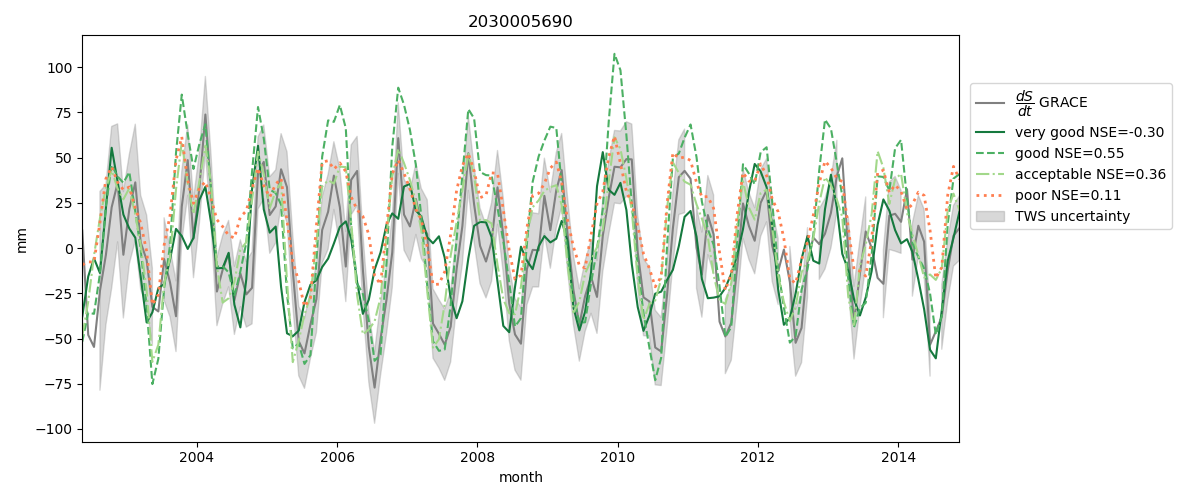

In [23]:
cmap_NSE=define_cmap_perf('NSE')[1]

plt.figure(figsize=(12,5))
plt.plot(TWSC[time_idx],color='gray',label='$\dfrac{dS}{dt}$ GRACE')
plt.fill_between(TWSC.index,TWSC-D_TWSC,TWSC+D_TWSC,color='gray',alpha=0.3,label='TWS uncertainty')
#NSE_best=compute_NSE(A_best[time_idx],TWSC[time_idx])
#plt.plot(A_best,linewidth=3,color=cmap_NSE(NSE_best),label='best NSE={:.2f}'.format(NSE_best))
plt.plot(A_vg[time_idx],color=cmap_NSE(0.8),label='very good NSE={:.2f}'.format(compute_NSE(A_vg[time_idx],TWSC[time_idx])))
plt.plot(A_g[time_idx],'--',color=cmap_NSE(0.6),label='good NSE={:.2f}'.format(compute_NSE(A_g[time_idx],TWSC[time_idx])))
plt.plot(A_p[time_idx],'-.',color=cmap_NSE(0.4),label='acceptable NSE={:.2f}'.format(compute_NSE(A_p[time_idx],TWSC[time_idx])))
plt.plot(A_vp[time_idx],':',linewidth=2,color='coral',label='poor NSE={:.2f}'.format(compute_NSE(A_vp[time_idx],TWSC[time_idx])))

plt.xlim([time_idx[0],time_idx[-1]])
#plt.xlim([TWSC.index[0],date(2016,12,15)])
#plt.ylim([1.05*np.min(TWSC[time_idx]-D_TWSC[time_idx]),1.05*np.max(TWSC[time_idx]+D_TWSC[time_idx])])
#plt.ylim([-90,100])
plt.ylabel('mm')
plt.xlabel('month')
plt.title(basin_id)
plt.legend(loc='upper right',bbox_to_anchor=(1.25,0.9))
plt.tight_layout()
plt.show()

# Statistics

Compute the number of basins in each category

In [24]:
stats_NSE_tab=np.sum(NSE_tab>=0.75,axis=0).to_frame(name='very good').T
stats_NSE_tab.loc['good']=np.sum(NSE_tab>=0.5,axis=0)
stats_NSE_tab.loc['acceptable']=np.sum(NSE_tab>=0.2,axis=0)

In [25]:
stats_NSE_tab

,P_CPC_ET_ERA5_Land_R_ERA5_Land_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS20_NOAH36_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS20_VIC412_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS21_CLSM25_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS21_VIC412_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GLDAS22_CLSM25_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_GRUN_TWS_GRACE_JPL_mascons,P_CPC_ET_ERA5_Land_R_MERRA2_TWS_GRACE_JPL_mascons,...,P_TRMM_ET_SSEBop_R_ERA5_Land_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS20_NOAH36_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS20_VIC412_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS21_CLSM25_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS21_VIC412_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GLDAS22_CLSM25_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_GRUN_TWS_GRACE_JPL_mascons,P_TRMM_ET_SSEBop_R_MERRA2_TWS_GRACE_JPL_mascons
very good,7,4,4,2,4,0,1,10,7,12,...,0,0,1,0,0,0,1,0,2,0
good,43,18,19,6,27,16,4,38,50,63,...,4,0,3,3,2,3,2,2,4,2
acceptable,91,31,45,31,44,55,32,71,103,108,...,4,1,4,4,4,4,4,4,4,4


In [4]:
#%run ../global_functions.py ./
#from matplotlib.cm import ScalarMappable

We define the best datasets combination as the one with the largest number of basins performing at least good

In [27]:
best_comb=datasets[np.argmax(stats_NSE_tab.loc['good'])]
best_comb

'P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_GRACE_JPL_mascons'

In [28]:
temp_max=NSE_tab[best_comb]
print('{} gives : \n {} basins very good (NSE >=0.75) \n {} basins good (NSE >=0.5) \n {} basins acceptable (NSE>=0.2) \n {} basins poor (NSE<0.2) \n {} basins unknown'.format(best_comb,np.sum(temp_max>=0.75),
                np.sum(temp_max>=0.5),
                np.sum(temp_max>=0.2),
                temp_max.loc[temp_max<0.2].shape[0],
                np.sum(np.isnan(temp_max)),
                ))

P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_GRACE_JPL_mascons gives : 
 44 basins very good (NSE >=0.75) 
 102 basins good (NSE >=0.5) 
 146 basins acceptable (NSE>=0.2) 
 48 basins poor (NSE<0.2) 
 0 basins unknown


<IPython.core.display.Javascript object>


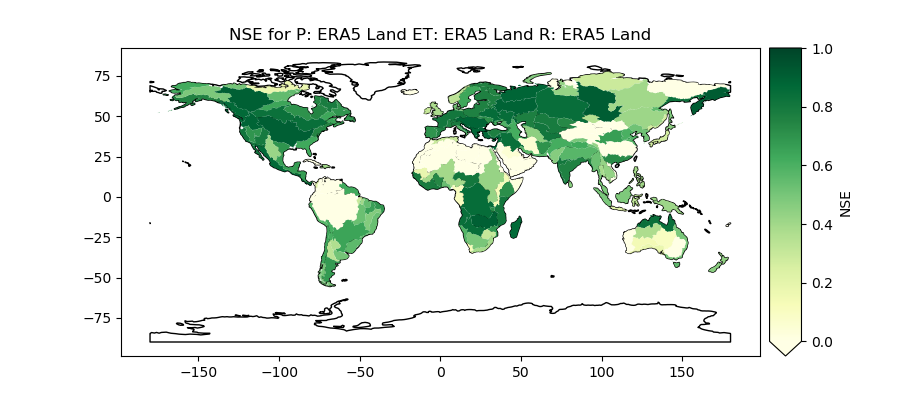

c:\users\fafal\miniconda3\lib\site-packages\geopandas\plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


In [31]:
basins=load_basins_data()
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

basins_plot=basins.loc[NSE_tab.index].copy()
basins_plot['best comb']=NSE_tab[best_comb]

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax, color='white', edgecolor='black')
basins_plot.plot(ax=ax,column='best comb',
                          legend=True,cax=cax,
                          missing_kwds={"color": "lightgrey",'hatch':'////'},
                          legend_kwds={'label': "NSE",'extend':'min'},
                         cmap=plt.cm.get_cmap('YlGn'), vmin=0,vmax=1)

ax.set_title("NSE for {}".format(best_comb[:-22].replace('P_','P: ').replace('ET_','ET: ').replace('R_','R: ').replace('_',' ')))
plt.show()

## Plot the difference between the best combination overall and the max NSE per basin

In [32]:
best_comb='P_GPCP_ET_GLEAM_R_GRUN_TWS_GRACE_JPL_mascons'

<IPython.core.display.Javascript object>


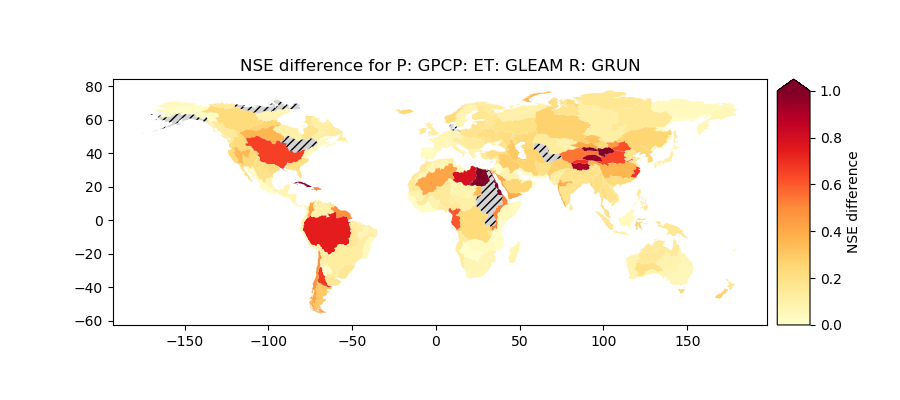

In [34]:
basins_plot=basins.loc[NSE_tab.index]
basins_plot['best comb overall']=NSE_tab[best_comb]
basins_plot['max NSE']=NSE_tab.max(axis=1)
basins_plot['diff']=basins_plot['max NSE']-basins_plot['best comb overall']


fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
basins_plot.plot(ax=ax,column='diff',
                          legend=True,cax=cax,
                          missing_kwds={"color": "lightgrey",'hatch':'////'},
                          legend_kwds={'label': "NSE difference",'extend':'max'},
                         cmap=plt.cm.get_cmap('YlOrRd'),vmin=0,vmax=1
                         ) 

ax.set_title("NSE difference for {}".format(best_comb[:-22].replace('P_','P: ').replace('ET_','ET: ').replace('R_','R: ').replace('_',' ')))
plt.show()

# About the NSE scale

In [36]:
basin_id=basins.index[np.random.randint(basins.shape[0])]
data_TWS='GRACE_JPL_mascons'

TWSC,D_TWSC=get_TWSC_filter(basin_id,data_TWS)

Translation from GRACE TWS variations

c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


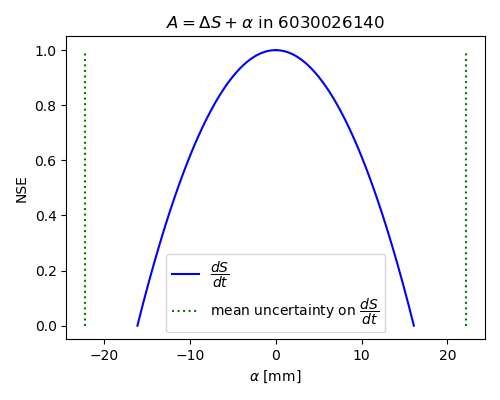

In [38]:
vecNSE=np.arange(0,1.01,0.001)
time_precise=pd.date_range(start=date(2004,1,1),end=date(2016,1,1),freq='SM')[::2]
alpha=np.sqrt(1-vecNSE)*np.sqrt(np.sum((TWSC-TWSC.mean())**2)/TWSC.shape[0])
bound=D_TWSC[time_precise].mean()

plt.figure(figsize=(5,4))
plt.plot(alpha,vecNSE,'b',label='$\dfrac{dS}{dt}$')
plt.plot(-alpha,vecNSE,'b')
plt.plot([bound]*2,[0,1],'g:',label='mean uncertainty on $\dfrac{dS}{dt}$')
plt.plot([-bound]*2,[0,1],'g:')
plt.ylabel('NSE')
plt.xlabel(r'$\alpha$ [mm]')
plt.title(r'$A=\Delta S + \alpha$ in '+str(basin_id))
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


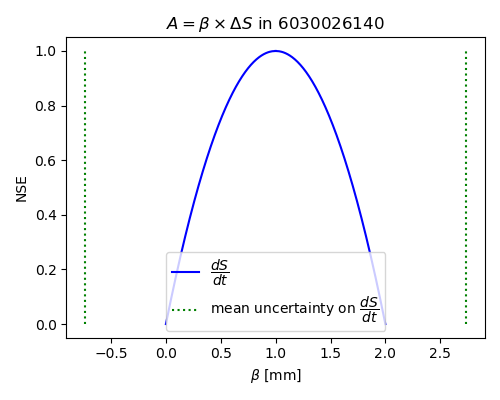

In [39]:
vecNSE=np.arange(0,1.01,0.001)
time_precise=pd.date_range(start=date(2004,1,1),end=date(2016,1,1),freq='SM')[::2]
beta1=1+np.sqrt(1-vecNSE)*np.sqrt(np.sum((TWSC-TWSC.mean())**2)/np.sum(TWSC**2))
beta2=1-np.sqrt(1-vecNSE)*np.sqrt(np.sum((TWSC-TWSC.mean())**2)/np.sum(TWSC**2))
bound1=1+D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()
bound2=1-D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()

plt.figure(figsize=(5,4))
plt.plot(beta1,vecNSE,'b',label='$\dfrac{dS}{dt}$')
plt.plot(beta2,vecNSE,'b')
plt.plot([bound1,bound1],[0,1],'g:',label='mean uncertainty on $\dfrac{dS}{dt}$')
plt.plot([bound2,bound2],[0,1],'g:')
plt.ylabel('NSE')
plt.xlabel(r'$\beta$ [mm]')
plt.title(r'$A=\beta \times \Delta S$ in '+str(basin_id))
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


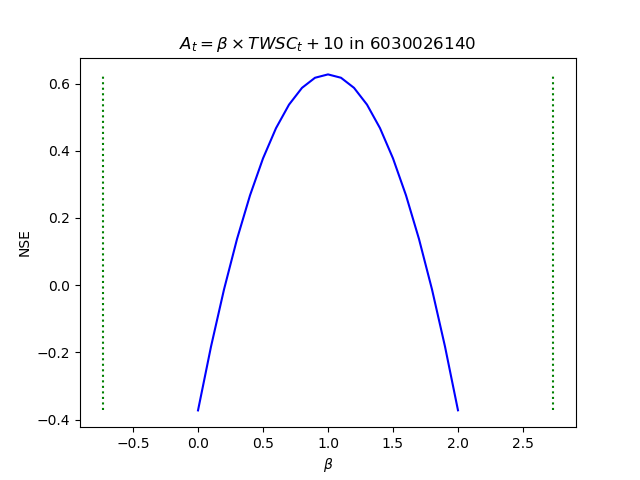

In [40]:
alpha=10

vec_beta=np.arange(0,2.1,0.1)
BY=(vec_beta-1).reshape(vec_beta.shape[0],1).dot((TWSC[time_precise].values).reshape(1,time_precise.shape[0]))
vec_NSE=1-np.sum((BY+alpha)**2,axis=1)/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)

bound1=1+D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()
bound2=1-D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()

plt.figure()
plt.plot(vec_beta,vec_NSE,'b')
plt.plot([bound1,bound1],[vec_NSE.min(),vec_NSE.max()],'g:')
plt.plot([bound2,bound2],[vec_NSE.min(),vec_NSE.max()],'g:')
plt.xlabel(r'$\beta$')
plt.ylabel('NSE')
plt.title(r'$A_t=\beta \times TWSC_t + {}$ in {}'.format(alpha,basin_id))
plt.show()

<IPython.core.display.Javascript object>


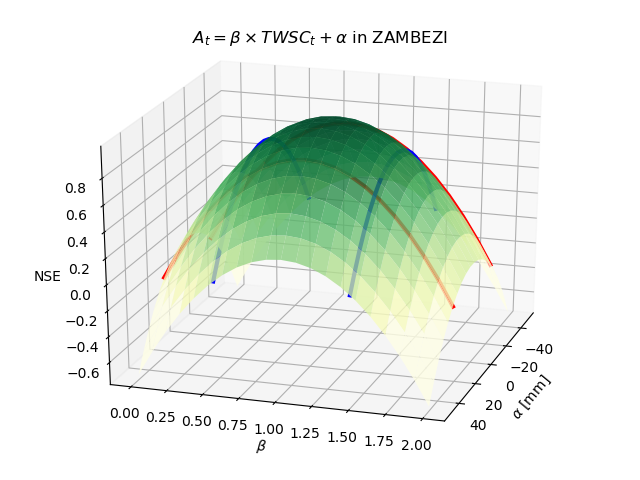

In [27]:
from mpl_toolkits.mplot3d import Axes3D

avec=np.linspace(-50,50,20)
bvec=np.arange(0,2.1,0.1)
(Avec,Bvec)=np.meshgrid(avec,bvec)
temp=np.zeros_like(Avec,dtype=float)
for t in time_precise:
    temp+=((Bvec-1)*TWSC.loc[t]+Avec)**2
NSE_vec=1-temp/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Avec,Bvec,NSE_vec,cmap=define_cmap_perf('NSE',discrete=False)[1],alpha=0.8)


bound_alpha=D_TWSC[time_precise].mean()
BY=(bvec-1).reshape(bvec.shape[0],1).dot((TWSC[time_precise].values).reshape(1,time_precise.shape[0]))
NSE_bound=1-np.sum((BY+bound_alpha)**2,axis=1)/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)
ax.plot(bound_alpha*np.ones_like(bvec),bvec,NSE_bound,linewidth=3,color='red')
ax.plot(-bound_alpha*np.ones_like(bvec),bvec,NSE_bound,linewidth=3,color='red')

bound_beta1=1+D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()
bound_beta2=1-D_TWSC[time_precise].mean()/np.abs(TWSC[time_precise]).mean()
NSE_bound1=np.zeros_like(avec)
NSE_bound2=np.zeros_like(avec)
for i,alpha in enumerate(avec):
    NSE_bound1[i]=1-np.sum((((bound_beta1-1)*TWSC[time_precise])+alpha)**2)/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)
    NSE_bound2[i]=1-np.sum((((bound_beta2-1)*TWSC[time_precise])+alpha)**2)/np.sum((TWSC[time_precise]-TWSC[time_precise].mean())**2)
ax.plot(avec,bound_beta1*np.ones_like(avec),NSE_bound1,linewidth=3,color='blue')
ax.plot(avec,bound_beta2*np.ones_like(avec),NSE_bound2,linewidth=3,color='blue')


ax.set_xlabel(r'$\alpha$ [mm]')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel('NSE')
ax.set_title(r'$A_t=\beta \times TWSC_t + \alpha$ in '+basin_name)
#ax.set_zlim([0,1])

fig.tight_layout()
plt.show()